# Rebuild estimation of feature count from using a grid method

#### Parameters that **have to be** adjustable:

- Size of the grid (i.e. how large is the side of each square)
- Size of the counting square (i.e. how large is the side of each counting square). To consider:
    - Size relative to grid square? Percentage of grid square side or of grid square area?
    - or make its size absolute? --> min > 0 & max = grid square side

### Parameters that **should** adjustable:

- inclusion / exclusion criteria:
    - on which sides of the square / cube is a ROI included / excluded
- position of the counting square:
    - upper left, upper center, upper right
    - middle left, middle center, middle right
    - lower left, lower center, lower right

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import measure
from shapely.geometry import Polygon, LineString
from shapely.validation import make_valid
import roifile
import cc3d

from typing import Dict, Tuple, List, Optional

### Classes:

In [2]:
class CountingSquare:
    
    def __init__(self, size: int, position: str, corners: Dict):
        self.size = size
        self.position = position
        self.all_corner_coords = corners
        self.bounding_box_roi = Polygon([corners['upper_left'], 
                                         corners['upper_right'], 
                                         corners['lower_right'], 
                                         corners['lower_left']])
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    
    def set_in_and_exclusion_sides(self, sides: List[str], passed_in_or_exclusion_sides: str='exclusion') -> None:
        self._assert_valid_input(sides = sides, passed_in_or_exclusion_sides = passed_in_or_exclusion_sides)
        if passed_in_or_exclusion_sides == 'exclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'exclusion')
        elif passed_in_or_exclusion_sides == 'inclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'inclusion')
        for in_or_exclusion_key in ['inclusion', 'exclusion']:
            for attribute_key in ['as_strings', 'as_lines']:
                setattr(self, f'{in_or_exclusion_key}_sides_{attribute_key}', in_and_exclusion_attributes[in_or_exclusion_key][attribute_key])
            
    
    def _assert_valid_input(self, sides: List[str], passed_in_or_exclusion_sides: str) -> None:
        sides_error_message = '"sides" has to be a list of two string elements, which can be any of these: "upper", "right", "lower", "left" - no duplicates!'
        if type(sides) == list:
            if len(sides) != 2:
                raise ValueError(sides_error_message)
            if sides[0] == sides[1]:
                raise ValueError()
            for elem in sides:
                if type(elem) != str:
                    raise TypeError(sides_error_message)
                if elem not in ['upper', 'right', 'lower', 'left']:
                    raise ValueError(sides_error_message)
        else:
            raise TypeError(sides_error_message)
        in_or_exclusion_error_message = '"passed_in_or_exclusion_sides" has to be either "exclusion" or "inclusion".'
        if type(passed_in_or_exclusion_sides) == str:
            if passed_in_or_exclusion_sides not in ['exclusion', 'inclusion']:
                raise ValueError(in_or_exclusion_error_message)
        else:
            raise TypeError(in_or_exclusion_error_message)             
    
           
    def _derive_in_and_exclusion_attributes(self, sides: List[str], in_or_exclusion: str) -> Dict:
        in_and_exclusion_attributes = {'inclusion': {},
                                       'exclusion': {}}
        in_and_exclusion_attributes[in_or_exclusion]['as_strings'] = sides
        in_and_exclusion_attributes[in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in sides]
        remaining_sides = ['upper', 'right', 'lower', 'left']
        for side_string in sides:
            remaining_sides.remove(side_string)
        if in_or_exclusion == 'inclusion':
            remaining_in_or_exclusion = 'exclusion'
        else:
            remaining_in_or_exclusion = 'inclusion'
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_strings'] = remaining_sides
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in remaining_sides]        
        return in_and_exclusion_attributes
    
    
    def _construct_line_shape_from_side_string(self, side_string: str) -> LineString:
        corner_point_keys = list(self.all_corner_coords.keys())
        corners = [key for key in corner_point_keys if side_string in key]
        starting_point_coords = self.all_corner_coords[corners[0]]
        end_point_coords = self.all_corner_coords[corners[1]]
        return LineString([starting_point_coords, end_point_coords])

In [3]:
class ImageTile:
    
    def __init__(self, tiles_row_id: int, tiles_col_id: int, tile: np.ndarray):
        self.row_id = tiles_row_id
        self.col_id = tiles_col_id
        self.image = tile
        self.height, self.width = tile.shape[0:2]
        self.all_corner_coords = self._calculate_all_corner_coords()
        self.bounding_box_roi = self._convert_corner_coords_to_bounding_box_roi()
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    def _convert_corner_coords_to_bounding_box_roi(self):
        coords = self.all_corner_coords
        return Polygon([coords['upper_left'], coords['upper_right'], coords['lower_right'], coords['lower_left']])
    
    def _calculate_all_corner_coords(self) -> Dict:
        upper_left = (self.row_id * self.height, self.col_id * self.width)
        shape = (self.height, self.width)
        all_corner_coords = self._corners_from_upper_left_corner_and_shape(upper_left = upper_left, shape = shape)
        return all_corner_coords
    
    def _corners_from_upper_left_corner_and_shape(self, upper_left: Tuple[int, int], shape: Tuple[int, int]) -> Dict:
        all_corner_coords = {}
        all_corner_coords['upper_left'] = upper_left
        all_corner_coords['upper_right'] = (upper_left[0], upper_left[1] + shape[1])
        all_corner_coords['lower_left'] = (upper_left[0] + shape[0], upper_left[1])
        all_corner_coords['lower_right'] = (upper_left[0] + shape[0], upper_left[1] + shape[1])   
        return all_corner_coords
    
    def create_counting_square(self, size: int, position: str, sides_to_exclude: List[str]):
        self._ensure_counting_square_fits_within_tile(size = size)
        counting_square_upper_left_corner_coords = self._get_upper_left_corner_coords_by_position(size = size, position = position)
        all_corners_counting_square = self._corners_from_upper_left_corner_and_shape(upper_left = counting_square_upper_left_corner_coords,
                                                                                     shape = (size, size))
        self.counting_square = CountingSquare(size = size, position = position, corners = all_corners_counting_square)
        self.counting_square.set_in_and_exclusion_sides(sides = sides_to_exclude)
        
    
    def _ensure_counting_square_fits_within_tile(self, size: int):
        if (size > self.height) or (size > self.width):
            error_message_line_1 = 'The "size" you have chosen for the counting square is too large!\n'
            error_message_line_2 = f'It has to fit within your grid with height = {self.height} and width = {self.width}.\n'
            error_message_line_3 = f'Thus, the max value you could select for "size" is {min(self.height, self.width)}.'
            error_message = error_message_line_1 + error_message_line_2 + error_message_line_3
            raise ValueError(error_message)
        
        
    def _get_upper_left_corner_coords_by_position(self, size: int, position: str) -> Tuple[int, int]:
        upper_row = self.all_corner_coords['upper_left'][0]
        middle_row = upper_row + int(self.height * 0.5) - int(size * 0.5)
        lower_row = self.all_corner_coords['lower_left'][0] - size
        left_col = self.all_corner_coords['upper_left'][1]
        center_col = left_col + int(self.width * 0.5) - int(size * 0.5)
        right_col = self.all_corner_coords['upper_right'][1] - size
        if position == 'upper left':
            return (upper_row, left_col)
        elif position == 'upper center':
            return (upper_row, center_col)
        elif position == 'upper right':
            return (upper_row, right_col)
        elif position == 'middle left':
            return (middle_row, left_col)
        elif position == 'middle center':
            return (middle_row, center_col)
        elif position == 'middle right':
            return (middle_row, right_col)
        elif position == 'lower left':
            return (lower_row, left_col)
        elif position == 'lower center':
            return (lower_row, center_col)
        elif position == 'lower right':
            return (lower_row, right_col)
        else:
            raise ValueError(f'Please double-check the "position" you passed.')

In [42]:
class GridEstimation:
    
    def __init__(self, instance_mask_zstack: np.ndarray, area_roi: Polygon, configs: Dict):
        self.configs = configs
        resized_mask_zstack, tiles = self._resize_grayscale_image_stack_and_create_tiles(image_stack = instance_mask_zstack.copy())
        overlapping_tiles = self._create_ImageTile_objects_for_all_tiles_overlapping_with_area_roi(tiles = tiles, area_roi = area_roi)
        self.label_ids_to_be_excluded = self._get_all_label_ids_that_match_exclusion_criteria(zstack = resized_mask_zstack, overlapping_tiles = overlapping_tiles)
        self.detected_features = self._quantify_features(zstack = resized_mask_zstack)
        self.quantified_area_in_square_px = self._calculate_total_area_of_counting_squares(overlapping_tiles = overlapping_tiles)
        self.bounding_boxes_xy_coords_for_plotting = self._extract_bounding_boxes_xy_coords(overlapping_tiles = overlapping_tiles)
        

    # adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
    def _resize_grayscale_image_stack_and_create_tiles(self, image_stack: np.ndarray) -> np.ndarray:
        image_height, image_width = image_stack.shape[1], image_stack.shape[2]
        tile_height, tile_width = self.configs['tile_height'], self.configs['tile_width']
        if (image_height % tile_height != 0) or (image_width % tile_width != 0):
            image_stack = self._resize_image_stack_for_tiles_by_padding_bottom_right(image_stack = image_stack)
            image_height, image_width  = image_stack.shape[1], image_stack.shape[2]
        representative_plane = image_stack[0]
        tiles = representative_plane.reshape(image_height // tile_height,
                                             tile_height,
                                             image_width // tile_width,
                                             tile_width)
        tiles = tiles.swapaxes(1,2)      
        return image_stack, tiles


    def _resize_image_stack_for_tiles_by_padding_bottom_right(self, image_stack: np.ndarray) -> np.ndarray:
        image_height, image_width = image_stack[0].shape
        pixels_required_for_height = self.configs['tile_height'] - image_height % self.configs['tile_height']
        pixels_required_for_width = self.configs['tile_width'] - image_width % self.configs['tile_width']
        return np.pad(image_stack, ((0,0), (0, pixels_required_for_height), (0, pixels_required_for_width)))
    

    def _create_ImageTile_objects_for_all_tiles_overlapping_with_area_roi(self, tiles: np.ndarray, area_roi: Polygon) -> List[ImageTile]:
        overlapping_tiles = []
        for row_id in range(tiles.shape[0]):
            for col_id in range(tiles.shape[1]):
                selected_tile = ImageTile(tiles_row_id = row_id, tiles_col_id = col_id, tile = tiles[row_id, col_id])
                if (selected_tile.bounding_box_roi.overlaps(area_roi)) or (selected_tile.bounding_box_roi.within(area_roi)):
                    selected_tile.create_counting_square(size = self.configs['counting_square_size'],
                                                         position = self.configs['counting_square_position'],
                                                         sides_to_exclude = self.configs['counting_square_exclusion_sides'])
                    overlapping_tiles.append(selected_tile)
        return overlapping_tiles
    
    
    def _get_all_label_ids_that_match_exclusion_criteria(self, zstack: np.ndarray, overlapping_tiles: np.ndarray) -> np.ndarray:
        label_ids_to_be_excluded = self._get_all_label_ids_touching_zstack_top_or_bottom(zstack = zstack)
        label_ids_to_be_excluded += self._get_all_label_ids_not_meeting_counting_square_inclusion_criteria(zstack = zstack, overlapping_tiles = overlapping_tiles)
        return label_ids_to_be_excluded                        
    
    
    def _get_all_label_ids_touching_zstack_top_or_bottom(self, zstack: np.ndarray) -> np.ndarray:
        label_ids_in_exclusion_plane = list(pd.unique(zstack[self.configs['exclude_first_or_last_zstack_plane']].flatten()))
        return remove_background_label_id(label_ids = label_ids_in_exclusion_plane)
    
    
    def _get_all_label_ids_not_meeting_counting_square_inclusion_criteria(self, zstack: np.ndarray, overlapping_tiles: np.ndarray) -> np.ndarray:
        all_label_id_matching_results = self._compare_all_label_id_rois_to_counting_square_rois(zstack = zstack, overlapping_tiles = overlapping_tiles)
        label_ids_matching_exclusion_criteria = self._get_all_label_ids_that_match_counting_square_exclusion_criteria(matching_results = all_label_id_matching_results)
        return remove_background_label_id(label_ids = label_ids_matching_exclusion_criteria)

        
    def _compare_all_label_id_rois_to_counting_square_rois(self, zstack: np.ndarray, overlapping_tiles: np.ndarray) -> Dict:
        all_label_id_matching_results = {}
        for plane_id in range(zstack.shape[0]):
            if self.configs['verbose']:
                print(f'Processing plane {plane_id + 1}/{zstack.shape[0]}')
            if (self.configs['exclude_first_or_last_zstack_plane'] == 0) & (plane_id == 0):
                continue
            elif (self.configs['exclude_first_or_last_zstack_plane'] == -1) & (plane_id == zstack.shape[0] - 1):
                continue
            else:
                single_plane = zstack[plane_id]
                unique_label_ids = list(pd.unique(single_plane.flatten()))
                unique_label_ids = remove_background_label_id(label_ids = unique_label_ids)
                for label_id in unique_label_ids:
                    all_label_id_matching_results[label_id] = {'overlapping_counting_squares': [],
                                                               'intersection_with_exclusion_lines': []}
                    roi = get_polygon_from_instance_segmentation(single_plane = single_plane, label_id = label_id)
                    for tile in overlapping_tiles:
                        if roi.overlaps(tile.counting_square.bounding_box_roi) or roi.within(tile.counting_square.bounding_box_roi):
                            if tile.counting_square not in all_label_id_matching_results[label_id]['overlapping_counting_squares']:
                                if len(all_label_id_matching_results[label_id]['overlapping_counting_squares']) > 0:
                                    print(f'Warning: {label_id} overlaps with multiple counting squares! This case is actually not properly dealt with yet!') 
                                all_label_id_matching_results[label_id]['overlapping_counting_squares'].append(tile.counting_square)
                                # set to False per default
                                all_label_id_matching_results[label_id]['intersection_with_exclusion_lines'].append(False)
                            lookup_index = all_label_id_matching_results[label_id]['overlapping_counting_squares'].index(tile.counting_square)
                            if (roi.intersects(tile.counting_square.exclusion_sides_as_lines[0]) or
                                roi.intersects(tile.counting_square.exclusion_sides_as_lines[1])):
                                all_label_id_matching_results[label_id]['intersection_with_exclusion_lines'][lookup_index] = True
        return all_label_id_matching_results
    
    
    def _get_all_label_ids_that_match_counting_square_exclusion_criteria(self, matching_results: Dict) -> List[int]:
        label_ids_to_exclude = []
        for label_id in matching_results.keys():
            overlaps_with_at_least_one_counting_square = len(matching_results[label_id]['overlapping_counting_squares']) > 0
            is_included_for_at_least_one_counting_square = False in matching_results[label_id]['intersection_with_exclusion_lines']
            if overlaps_with_at_least_one_counting_square & is_included_for_at_least_one_counting_square:
                continue
            else:
                label_ids_to_exclude.append(label_id)
        return label_ids_to_exclude


    def _quantify_features(self, zstack: np.ndarray) -> int:
        zstack = self._remove_label_ids_from_zstack(zstack = zstack)
        _, feature_count = cc3d.connected_components(zstack, return_N=True)
        return feature_count
    
    
    def _remove_label_ids_from_zstack(self, zstack: np.ndarray) -> np.ndarray:
        zstack[np.isin(zstack, self.label_ids_to_be_excluded)] = self.configs['background_label_id']
        return zstack


    def _calculate_total_area_of_counting_squares(self, overlapping_tiles: List[ImageTile]) -> int:
        n_counting_squares = len(overlapping_tiles)
        area_single_counting_square = overlapping_tiles[0].counting_square.bounding_box_roi.area
        return n_counting_squares * area_single_counting_square    


    def _extract_bounding_boxes_xy_coords(self, overlapping_tiles: List[ImageTile]) -> Dict:
        xy_coords = {'image_tiles': [],
                     'counting_squares': {'inclusion_sides': [],
                                          'exclusion_sides': []}}
        for tile in overlapping_tiles:
            grid_x_coords = tile.bounding_box_x_for_plotting
            grid_y_coords = tile.bounding_box_y_for_plotting
            xy_coords['image_tiles'].append((grid_x_coords, grid_y_coords))
            counting_square_exclusion_sides = []
            for i in range(2):
                x_coords = tile.counting_square.exclusion_sides_as_lines[i].xy[1]
                y_coords = tile.counting_square.exclusion_sides_as_lines[i].xy[0]
                counting_square_exclusion_sides.append((x_coords, y_coords))
            xy_coords['counting_squares']['exclusion_sides'].append(counting_square_exclusion_sides)
            counting_square_inclusion_sides = []
            for i in range(2):
                x_coords = tile.counting_square.inclusion_sides_as_lines[i].xy[1]
                y_coords = tile.counting_square.inclusion_sides_as_lines[i].xy[0]
                counting_square_inclusion_sides.append((x_coords, y_coords))
            xy_coords['counting_squares']['inclusion_sides'].append(counting_square_inclusion_sides)
        return xy_coords
    
    
    def inspect_grid_results_in_2D(self, zstack: np.ndarray, area_roi: Polygon, figsize: Tuple[int, int]=(15, 16)) -> None:
        zstack_max = np.max(zstack, axis=0)
        grid_zstack = zstack.copy()
        grid_zstack = self._remove_label_ids_from_zstack(zstack = grid_zstack)
        grid_zstack_max = np.max(grid_zstack, axis=0)
        xy_coords = self.bounding_boxes_xy_coords_for_plotting
        fig = plt.figure(figsize=figsize, facecolor='white')
        gs = fig.add_gridspec(1,2)
        
        fig.add_subplot(gs[0,0])
        plt.imshow(zstack_max)
        plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0], c='white')
        plt.title('Original instance segmentation input')
        
        fig.add_subplot(gs[0,1])
        plt.imshow(grid_zstack_max)
        n_tiles = len(self.bounding_boxes_xy_coords_for_plotting['image_tiles'])
        for tile_idx in range(n_tiles):
            plt.plot(xy_coords['image_tiles'][tile_idx][0], xy_coords['image_tiles'][tile_idx][1])
            for side_idx in range(2):
                plt.plot(xy_coords['counting_squares']['inclusion_sides'][tile_idx][side_idx][0], 
                         xy_coords['counting_squares']['inclusion_sides'][tile_idx][side_idx][1], c='green')
                plt.plot(xy_coords['counting_squares']['exclusion_sides'][tile_idx][side_idx][0], 
                         xy_coords['counting_squares']['exclusion_sides'][tile_idx][side_idx][1], c='red')
        plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0], c='white')
        plt.title(f'Quantified features after applying exclusion criteria [n = {self.detected_features}]')
        if self.configs['exclude_first_or_last_zstack_plane'] == 0:
            excluded_plane = 'lowest'
        elif self.configs['exclude_first_or_last_zstack_plane'] == -1:
            excluded_plane = 'upper most'
        title_line_1 = f'Grid estimation with a tile size of {self.configs["tile_height"]}x{self.configs["tile_width"]} px, '
        title_line_2 = f'a counting square size of {self.configs["counting_square_size"]}x{self.configs["counting_square_size"]} px,\n'
        title_line_3 = f'and the {excluded_plane} plane of the zstack being used as exclusion plane'
        plt.suptitle(title_line_1 + title_line_2 + title_line_3, y=0.78)
        
        if self.configs['save_plot']:
            filename = f'{self.configs["file_id"]}_Grid_estimation_{self.configs["tile_height"]}x{self.configs["tile_width"]}-tiles_{self.configs["counting_square_size"]}x{self.configs["counting_square_size"]}-squares.png'
            plt.savefig(self.configs['plot_output_path'].joinpath(filename), dpi=300)
        if self.configs['show_plot']:
            plt.show()
        else:
            plt.close()

### Functions:

In [5]:
"""
# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
def resize_image_and_create_tiles(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    if len(image.shape) == 3:
        image_height, image_width, image_channels = image.shape # might crash with grayscale images?
        tile_height, tile_width = tile_size
        if (image_height % tile_height != 0) or (image_width % tile_width != 0):
            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)
            image_height, image_width, image_channels = image.shape
        tiles = image.reshape(image_height // tile_height,
                              tile_height,
                              image_width // tile_width,
                              tile_width, 
                              image_channels)
        tiles = tiles.swapaxes(1,2)
    else:
        image_height, image_width = image.shape # might crash with grayscale images?
        tile_height, tile_width = tile_size
        if (image_height % tile_height != 0) or (image_width % tile_width != 0):
            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)
            image_height, image_width = image.shape
        tiles = image.reshape(image_height // tile_height,
                              tile_height,
                              image_width // tile_width,
                              tile_width)
        tiles = tiles.swapaxes(1,2)        
    return image, tiles


def _resize_image_for_tiles_by_padding_bottom_right(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image.shape[:2]
    pixels_required_for_height = tile_size[0] - image_height % tile_size[0]
    pixels_required_for_width = tile_size[1] - image_width % tile_size[1]
    if len(image.shape) == 3:
        return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width), (0, 0)))
    else:
        return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width)))
"""


'\n# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7\ndef resize_image_and_create_tiles(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:\n    if len(image.shape) == 3:\n        image_height, image_width, image_channels = image.shape # might crash with grayscale images?\n        tile_height, tile_width = tile_size\n        if (image_height % tile_height != 0) or (image_width % tile_width != 0):\n            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)\n            image_height, image_width, image_channels = image.shape\n        tiles = image.reshape(image_height // tile_height,\n                              tile_height,\n                              image_width // tile_width,\n                              tile_width, \n                              image_channels)\n        tiles = tiles.swapaxes(1,2)\n    else:\n        image_height, image_width = im

In [6]:
# from utils

def listdir_nohidden(path: Path) -> List:
    return [f for f in os.listdir(path) if f.startswith('.') == False]


def load_zstack_as_array_from_single_planes(path: Path, file_id: str, 
                                            minx: Optional[int]=None, maxx: Optional[int]=None, 
                                            miny: Optional[int]=None, maxy: Optional[int]=None) -> np.ndarray:
    types = list(set([type(minx), type(maxx), type(miny), type(maxy)]))    
    if any([minx, maxx, miny, maxy]):
        if (len(types) == 1) & (types[0] == int):
            cropping = True
        else:
            raise TypeError("'minx', 'maxx', 'miny', and 'maxy' all have to be integers - or None if no cropping has to be done")
    else:
        cropping = False
    filenames = [filename for filename in listdir_nohidden(path) if filename.startswith(file_id)]
    cropped_zstack = list()
    for single_plane_filename in filenames:
        tmp_image = imread(path.joinpath(single_plane_filename))
        if cropping:
            tmp_image = tmp_image[minx:maxx, miny:maxy]
        cropped_zstack.append(tmp_image.copy())
        del tmp_image
    return np.asarray(cropped_zstack)


def get_polygon_from_instance_segmentation(single_plane: np.ndarray, label_id: int) -> Polygon:
    x_dim, y_dim = single_plane.shape
    tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
    tmp_array[np.where(single_plane == label_id)] = 1
    tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
    roi = Polygon(tmp_contours)
    if roi.is_valid == False:
        roi = make_valid(roi)
    return roi

In [7]:
# has to go to utils!
def remove_background_label_id(label_ids: List[int], background_label_id: int=0) -> List[int]:
    while background_label_id in label_ids:
        label_ids.remove(background_label_id)
    return label_ids

## Testing:

In [8]:
grid_estimation_configs = {'tile_height': 500,
                           'tile_width': 500,
                           'counting_square_size': 250,
                           'counting_square_position': 'middle center',
                           'counting_square_exclusion_sides': ['right', 'lower'],
                           'exclude_first_or_last_zstack_plane': -1,
                           'background_label_id': 0,
                           'verbose': True}

In [9]:
mask_zstack = load_zstack_as_array_from_single_planes(path = Path('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/instance_segmentations/'), file_id = '0000')
mask_zstack_to_quantify_for_grid_estimation = mask_zstack.copy()
mask_zstack_to_quantify_for_grid_estimation.shape

(13, 5568, 4189)

In [10]:
loaded_roi = roifile.ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/0000.roi')
row_coords = loaded_roi.coordinates()[:, 1]
col_coords = loaded_roi.coordinates()[:, 0]
area_roi = Polygon(np.asarray(list(zip(row_coords, col_coords))))

In [11]:
grid_estimator = GridEstimation(instance_mask_zstack=mask_zstack_to_quantify_for_grid_estimation, area_roi = area_roi, configs = grid_estimation_configs)

Processing plane 1/13
Processing plane 2/13
Processing plane 3/13
Processing plane 4/13
Processing plane 5/13
Processing plane 6/13
Processing plane 7/13
Processing plane 8/13
Processing plane 9/13
Processing plane 10/13
Processing plane 11/13
Processing plane 12/13
Processing plane 13/13


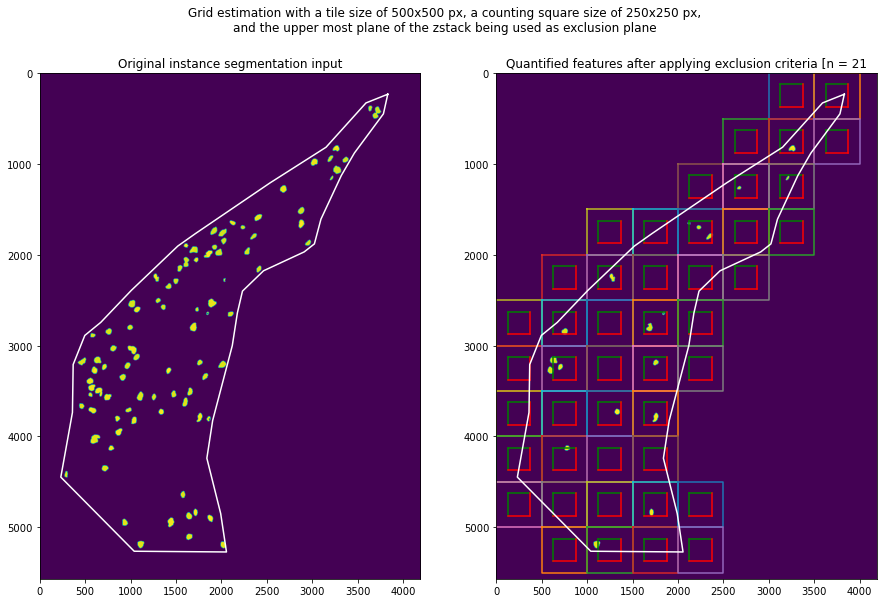

In [12]:
grid_estimator.inspect_grid_results_in_2D(zstack = mask_zstack.copy(), area_roi = area_roi)

## Interface between findmycells Project & GridEstimation:

In [11]:
import sys
sys.path.append('/home/workstation/GitHub_Repos/DCLmeetsRETUNE/image_analysis_pipeline/')
import findmycells

from findmycells.main import Project

In [36]:
grid_estimation_configs = {'file_id': '0000',
                           'area_id': 'SNpc_lat',
                           'tile_height': 500,
                           'tile_width': 500,
                           'counting_square_size': 250,
                           'counting_square_position': 'middle center',
                           'counting_square_exclusion_sides': ['right', 'lower'],
                           'exclude_first_or_last_zstack_plane': -1,
                           'background_label_id': 0,
                           'show_plot': True,
                           'save_plot': False,
                           'verbose': True}

In [37]:
def simulate_grid_estimation(fmc_project: Project, configs: Dict) -> GridEstimation:
    configs['plot_output_path'] = fmc_project.database.inspection_dir
    mask_zstack = load_zstack_as_array_from_single_planes(path = fmc_project.database.quantified_segmentations_dir.joinpath('SNpc_lat'), file_id = configs['file_id'])
    mask_zstack_to_quantify_for_grid_estimation = mask_zstack.copy()
    area_roi = fmc_project.database.area_rois_for_quantification[configs['file_id']]['all_planes'][configs['area_id']]
    grid_estimator = GridEstimation(instance_mask_zstack=mask_zstack_to_quantify_for_grid_estimation, area_roi = area_roi, configs = grid_estimation_configs)
    grid_estimator.inspect_grid_results_in_2D(zstack = mask_zstack, area_roi = area_roi)

In [29]:
project_root_dir = Path('/mnt/d/Dennis_Alex/findmycells_projects/TH_in_SN_3D_multi_rois_all_rois_ens_12_test_df2_v0-1-7/')

In [30]:
segmentation_configs = {'cellpose': {'model_type': 'nuclei', #one of: 'cyto', 'cyto2', or 'nuclei'
                                     'net_avg': True}}

In [31]:
quantification_configs = {'exclusion_criteria': {'min_roi_area_size': 425}}

In [32]:
user_input_via_gui = {'project_root_dir': project_root_dir,  
                      'segmentation_configs': segmentation_configs,
                      'quantification_configs': quantification_configs,
                      'clear_temp_zarrs_from_sys_tmp': True}

In [33]:
th_in_sn = Project(user_input_via_gui)

In [34]:
th_in_sn.load_status()

Processing plane 1/13
Processing plane 2/13
Processing plane 3/13
Processing plane 4/13
Processing plane 5/13
Processing plane 6/13
Processing plane 7/13
Processing plane 8/13
Processing plane 9/13
Processing plane 10/13
Processing plane 11/13
Processing plane 12/13
Processing plane 13/13


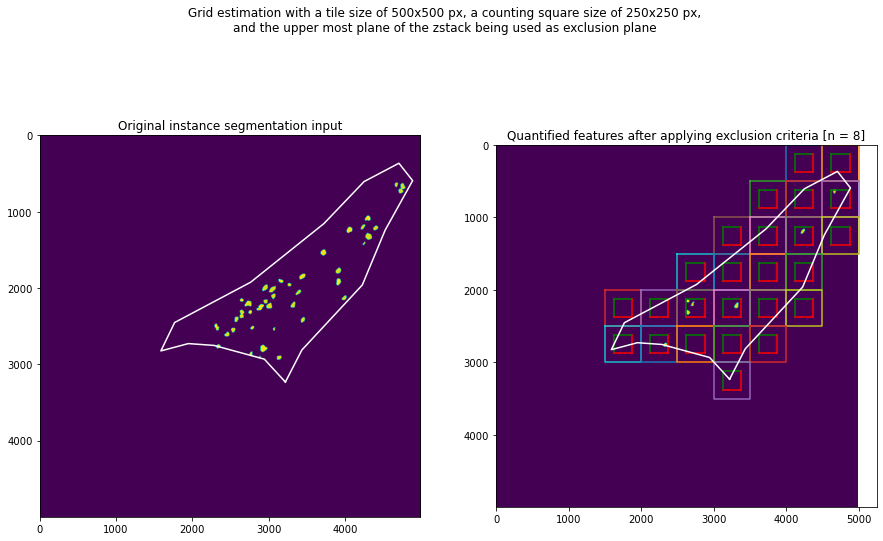

In [43]:
simulate_grid_estimation(fmc_project = th_in_sn, configs = grid_estimation_configs)

# Issue detected:

When the postprocessed version of the instance segmentation mask is used (the one that is saved in the quantified_segmentations_dir) - all features outside of the area_roi were already removed. However, when using the GridEstimation, counting squares will most likely also reside a little outside of the area_roi and thus removing all features outside of it will bias the GridEstimation towards finding less ROIs! Is re-post-processing really the only way? Takes so long...